# Question 1.1

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
df = pd.read_csv('A1_co2.txt', sep=" ")
df.head()

,year,month,time,co2
0,1958,3,1958.208,315.71
1,1958,4,1958.292,317.45
2,1958,5,1958.375,317.50
3,1958,6,1958.458,317.10
4,1958,7,1958.542,315.86


> You should not use the observations for years 2018 and 2019 (Last 20 observations) for estimations/training - only for comparisons/testing.

In [121]:
# Let the train set be the measurements before 2018, and the test set be the measurements after 2018
train = df[df['year'] < 2018]
test = df[df['year'] >= 2018]

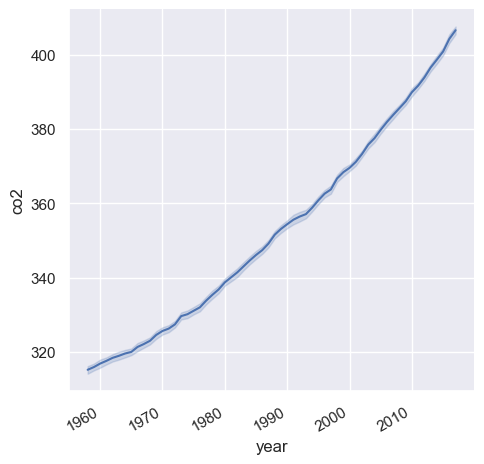

In [122]:
# TODO: Plot test and train set together

import seaborn as sns

# Plot the train set
g = sns.relplot(x="year", y="co2", kind="line", data=train)
g.fig.autofmt_xdate()



# Question 1.2

In [123]:
min_date = df['year'].min()
max_date = df['year'].max()
print(min_date, max_date)

1958 2019


## Question 1.2.1

In [124]:
MONTHS_IN_YEAR = 12

X = np.vstack(
    [
        np.ones_like(train["time"]),
        train["time"],
        np.sin(2 * np.pi / MONTHS_IN_YEAR * (train["month"] - 1)),
        np.cos(2 * np.pi / MONTHS_IN_YEAR * (train["month"] - 1)),
    ]
).T

In [125]:
y = train["co2"].values

In [126]:
beta_hat, _, _, _ = np.linalg.lstsq(X, y)
beta_hat

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_63929/2767225113.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_hat, _, _, _ = np.linalg.lstsq(X, y)


array([-2.70966921e+03,  1.54048858e+00,  2.79666606e+00, -3.37828870e-01])

## Question 1.2.2

In [127]:
N, p = X.shape

residuals = y - X @ beta_hat

sigma_hat2 = np.sum(residuals ** 2) / (N - p)
sigma_hat2

12.185006902038825

In [128]:
beta_hat_var = sigma_hat2 * np.linalg.inv(X.T @ X)
beta_hat_var

array([[ 2.24882564e+02, -1.13106724e-01, -3.04580858e-02,
         8.25588856e-03],
       [-1.13106724e-01,  5.68923456e-05,  1.53322444e-05,
        -4.10820940e-06],
       [-3.04580858e-02,  1.53322444e-05,  3.38749771e-02,
         3.99555742e-05],
       [ 8.25588856e-03, -4.10820940e-06,  3.99555742e-05,
         3.40133872e-02]])

<AxesSubplot: >

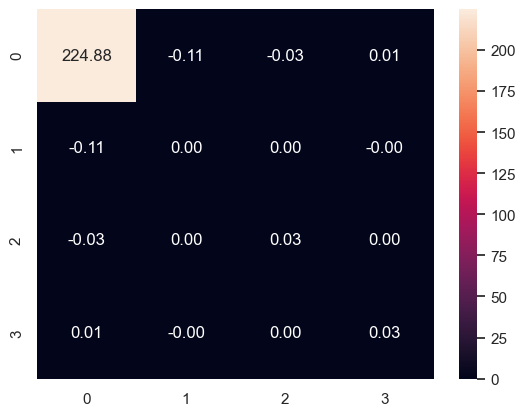

In [129]:
# Heatmap of the variance of the coefficients
sns.heatmap(beta_hat_var, annot=True, fmt=".2f")

## Question 1.2.3

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_63929/1962216804.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


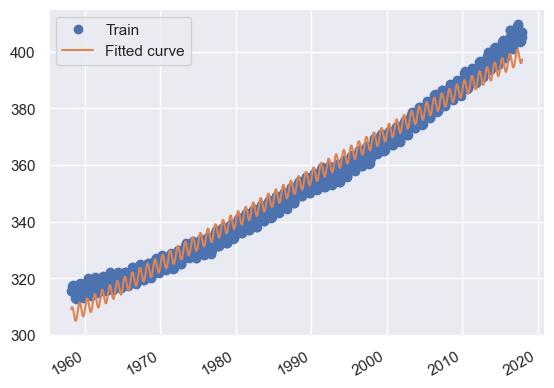

In [130]:

y_hat = X @ beta_hat

# Plot the train set and the fitted curve

fig, ax = plt.subplots()

ax.plot(train["time"], train["co2"], "o", label="Train")
ax.plot(train["time"], y_hat, label="Fitted curve")

ax.legend()

fig.autofmt_xdate()
fig.show()

## Question 1.2.4

Plan-of-attack: Relaxtion algorithm

In [131]:
def is_converged(beta1, beta2, tol=1e-5):
    return np.linalg.norm(beta1 - beta2) < tol


Sigma = np.eye(p) * sigma_hat2

beta = beta_hat

while True:
    Sigma_inv = np.linalg.inv(Sigma)

    Sigma = np.linalg.inv(X.T @ X / sigma_hat2 + Sigma_inv)

    beta_new = Sigma @ (X.T @ y / sigma_hat2 + Sigma_inv @ beta)

    if is_converged(beta, beta_new):
        break

    beta = beta_new

beta

array([-2.70966921e+03,  1.54048858e+00,  2.79666606e+00, -3.37828870e-01])